# Project Part 3: Adversarial, Transferability and Robustification



We recommand you to use Google Colab to edit and run this notebook. You can also install jupyter on your own computer.

In [1]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## 0. Prepare data

You can familiarise yourself with MNIST, a small size dataset, on its Wikipedia article [https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database). MNIST is composed of 28x28 grayscaled images of handwritten digits. This is a classification task with 10 classes (10 digits).

In [2]:
# Data Loading
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


100%|██████████| 9912422/9912422 [00:00<00:00, 110348893.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38962912.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25224921.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10319896.41it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



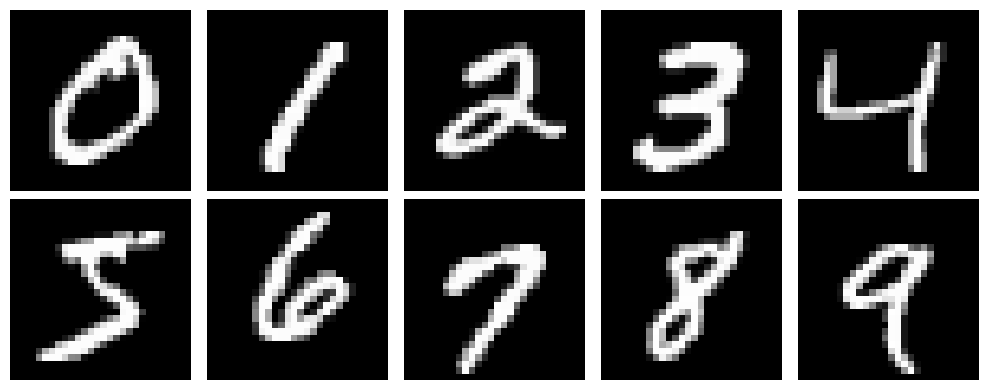

In [3]:
import torchvision

mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

# plot  image for each digit from 0 to 9.
plt.figure(figsize=(10, 4))

for digit in range(10):
    digit_indices = [index for index, label in enumerate(mnist_dataset.targets) if label == digit]
    index = digit_indices[0]  # Select the first example for each digit
    image, _ = mnist_dataset[index]

    plt.subplot(2, 5, digit + 1)
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
x = mnist["data"]
y = mnist["target"]

In [5]:
# Data exploration
# it is important how we present data to the model.

print(f"Shape of x: {x.shape}")
print(f"Min, max x: {x.min(), x.max()}")
print(f"Shape of y: {y.shape}")
print(f"Classes in y: {np.unique(y)}")

Shape of x: (70000, 784)
Min, max x: (0.0, 255.0)
Shape of y: (70000,)
Classes in y: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [6]:
# Pre-processing
x = torch.from_numpy(x.astype(float)).float()
y = torch.from_numpy(y.astype(int)).type(torch.LongTensor)
# Shape
x = x.reshape(-1, 1, 28, 28)
# Scaler
x = (x - x.min()) / (x.max() - x.min())


In [7]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

## 1. Adversarial examples

The goal of this first part is to generate adversarial examples on a simple dataset called MNIST. MNIST is a dataset of 28x28 black and white images that represents hand-written digits, and their associate label 0,1,...,9.

You can use the following ressource to help you [https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#).


1. Train a Neural Network using the PyTorch library.

The architecture of the models and the training hyper-parameters are given below.
We recommend using these parameters, the SGD optimizer and the Cross Entropy loss.


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):    #  'forward' method
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [9]:
learning_rate = 0.001
momentum = 0.9
epochs = 10
batch_size = 64

In [11]:
# dataloader for train, test, validation. It is a target tensor.

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 64

# initiate data loaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [12]:
import torch.optim as optim

# start first/null model
model_0 = Net()

# optimizer (SGD) with learning rate and momentum.
learning_rate = 0.01
momentum_parametr = 0.9
optimizer = optim.SGD(model_0.parameters(), lr = learning_rate, momentum = momentum_parametr)

In [13]:
def train_model(model, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs):
    train_dataset = TensorDataset(x_train, y_train)     # the same as two previous blocks.
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(dataset=val_dataset, batch_size=2000, shuffle=True,)

    train_losses = []  # To store training losses for each epoch
    val_losses = []    # To store validation losses for each epoch

    # train loop
    for e in range(epochs):
        model.train()  # to set the model to training mode
        train_loss = 0.0

        for batch_data, batch_labels in tqdm(train_loader, desc=f'Epoch {e + 1}/{epochs}'):
            optimizer.zero_grad()       # clear gradients
            output = model(batch_data)  # this is forward pass
            loss = loss_func(output, batch_labels)  # computes loss
            loss.backward()                         # Backpropagation
            optimizer.step()                        # Update weights
            train_loss += loss.item()

        # average training loss for the epochs
        avg_train_loss = train_loss / len(train_loader)

        model.eval()         # model is set to evaluation mode.
        val_loss = 0.0

        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                output = model(batch_data)              # Forward pass
                loss = loss_func(output, batch_labels)  # Compute loss
                val_loss += loss.item()

        # avg. validation loss in the epoch
        avg_val_loss = val_loss / len(val_loader)

        #  train and validation loss per epoch
        print(f'Epoch {e + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()



Epoch 1/10: 100%|██████████| 700/700 [00:15<00:00, 43.92it/s]


Epoch 1/10, Training Loss: 0.8246, Validation Loss: 0.1523


Epoch 2/10: 100%|██████████| 700/700 [00:15<00:00, 44.81it/s]


Epoch 2/10, Training Loss: 0.3370, Validation Loss: 0.1202


Epoch 3/10: 100%|██████████| 700/700 [00:15<00:00, 46.19it/s]


Epoch 3/10, Training Loss: 0.2625, Validation Loss: 0.0930


Epoch 4/10: 100%|██████████| 700/700 [00:16<00:00, 42.41it/s]


Epoch 4/10, Training Loss: 0.2263, Validation Loss: 0.0834


Epoch 5/10: 100%|██████████| 700/700 [00:15<00:00, 45.90it/s]


Epoch 5/10, Training Loss: 0.2049, Validation Loss: 0.0743


Epoch 6/10: 100%|██████████| 700/700 [00:15<00:00, 46.24it/s]


Epoch 6/10, Training Loss: 0.1895, Validation Loss: 0.0732


Epoch 7/10: 100%|██████████| 700/700 [00:15<00:00, 45.66it/s]


Epoch 7/10, Training Loss: 0.1773, Validation Loss: 0.0688


Epoch 8/10: 100%|██████████| 700/700 [00:15<00:00, 45.30it/s]


Epoch 8/10, Training Loss: 0.1676, Validation Loss: 0.0660


Epoch 9/10: 100%|██████████| 700/700 [00:15<00:00, 45.90it/s]


Epoch 9/10, Training Loss: 0.1627, Validation Loss: 0.0599


Epoch 10/10: 100%|██████████| 700/700 [00:15<00:00, 44.93it/s]


Epoch 10/10, Training Loss: 0.1549, Validation Loss: 0.0611


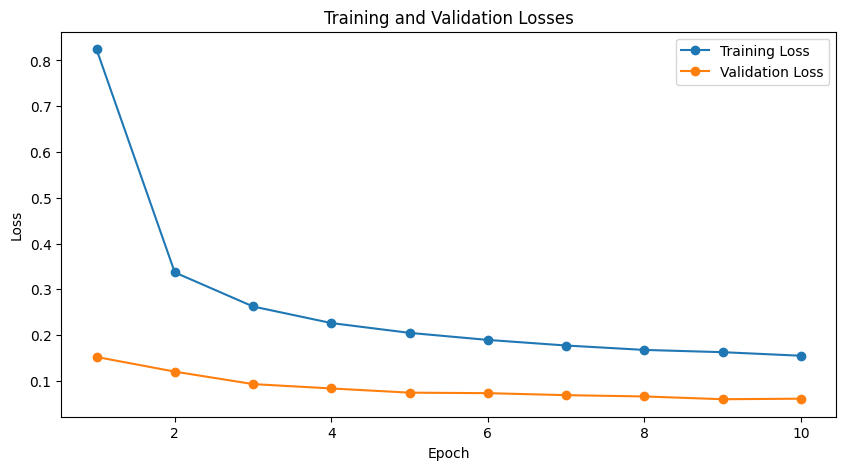

In [14]:
# to call the train_model function
train_model(model_0, x_train, y_train, x_val, y_val, optimizer, batch_size = 64, loss_func = nn.CrossEntropyLoss(), epochs = 10)

2. Evaluate clean accuracy of the Neural Network using a test set that has not been used for training.

In [ ]:
model_0.eval()  # to set model_0 to evaluation phase.

# DataLoader for the test data
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# model accuracy on test data :
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for test_data, test_labels in test_loader:
        output = model_0(test_data)
        _, predicted = torch.max(output, 1)
        total_samples += test_labels.size(0)
        correct_predictions += (predicted == test_labels).sum().item()

# accuracy computed here :
accuracy = correct_predictions / total_samples *100

print(f"Clean accuracy of the model is {accuracy:.4f}.")


Clean accuracy of the model is 98.4429.


3. Implement and execute the PGD attack on 1000 examples of the testing set. The hyperparameters of PGD are given below.
The perturbation is bounded by a maximum L-infinity norm, called epsilon (eps), which means that each pixel can be perturbed between -eps and +eps. We initialy set the maximum perturbation to eps = 32/255. For simplicity, you can set the step size alpha = epsilon / 10, and run PGD with only one random restart.

You can find the description of PGD in the paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083) and an example of another adversarial attack on the PyTorch documentation [https://pytorch.org/tutorials/beginner/fgsm_tutorial.html](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).
Tips: use the F.cross_entropy loss during the attack.


In [27]:
num_images_to_attack = 1000   # the PGD attack is applied to 1000 images (examples).
epsilon = 32/255
n_iter = 50
alpha = epsilon / 10          #  alpha or step size determines how much  input is perturbed in direction of gradient.

In [34]:
# model takes epsilon

def pgd_attack(model, images, labels, epsilon, alpha, num_steps):   # images : input  |  label = target |
    """
    PGD attack on batch of images.
    """
    images.requires_grad = True

    for _ in range(num_steps):
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # PGD update
        with torch.no_grad():
            images_grad = images.grad.data  # extract the gradient of loss with respect to input.
            images = torch.clamp(images + alpha * torch.sign(images_grad), 0, 1)
            images = torch.clamp(images, 0, 1)

    return images.detach()

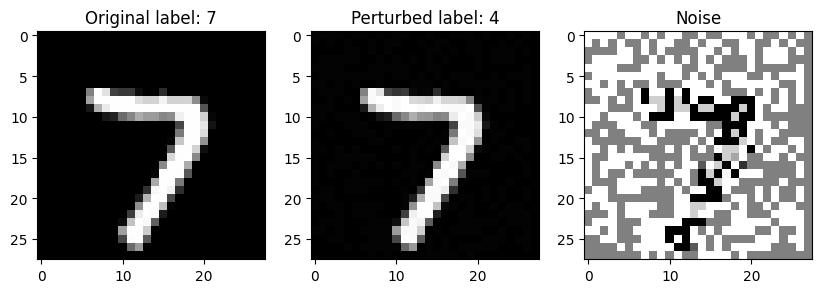

In [36]:

def plot_images(original, perturbed, noise, label_original, label_perturbed):
    plt.figure(figsize=(10, 4))

    # original image
    plt.subplot(1, 3, 1)
    if original.shape[-1] == 1:
        original = np.squeeze(original, axis=-1)
    plt.imshow(original, cmap='gray')  # 'gray' for grayscale image
    plt.title(f'Original label: {label_original}')

    # perturbed image
    plt.subplot(1, 3, 2)
    if perturbed.shape[-1] == 1:
        perturbed = np.squeeze(perturbed, axis=-1)
    plt.imshow(perturbed, cmap='gray')
    plt.title(f'Perturbed label: {label_perturbed}')

        # noise
    plt.subplot(1, 3, 3)
    if noise.shape[-1] == 1:
        noise = np.squeeze(noise, axis=-1)
    plt.imshow(noise, cmap='gray')
    plt.title('Noise')

    plt.show()

# PGD attack on 1000 examples from the testing set
num_images_to_attack = 1  # changeeable
count = 0
num_steps = 1

for images, labels in test_dataloader:
    if count >= num_images_to_attack:
        break

    perturbed_images = pgd_attack(model_0, images.clone(), labels, epsilon, alpha, num_steps)

    # images to np arrays for visualization.
    original_image_np = np.transpose(images[0].numpy(), (1, 2, 0))                # dimension 1 of the input become dimension 0 in the output, etc.
    perturbed_image_np = np.transpose(perturbed_images[0].numpy(), (1, 2, 0))

    noise = perturbed_image_np - original_image_np                                # to plot noise as well.

    #  predictions for the perturbed images
    outputs_perturbed = model_0(perturbed_images)
    _, predicted = torch.max(outputs_perturbed, 1)

    plot_images(original_image_np, perturbed_image_np, noise, labels[0].item(), predicted[0].item())

    count += 1

4. Show the robust accuracy of model_0, that is the accuracy of the model on the adversarial examples.

In [37]:
model_0.eval()

correct_robust = 0
total_robust = 0

# go via test dataset
for images, labels in test_dataloader:
    perturbed_images = pgd_attack(model_0, images.clone(), labels, epsilon, alpha, num_steps)       # PGD attack

    # Evaluate the perturbed images using the model
    outputs = model_0(perturbed_images)
    _, predicted = torch.max(outputs, 1)

    # re-new statistics
    total_robust += labels.size(0)
    correct_robust += (predicted == labels).sum().item()

#  robust accuracy
robust_accuracy = correct_robust / total_robust

print(f"Robust accuracy of the model is {robust_accuracy * 100:.2f}%.")

Robust accuracy of the model is 9.75%.


5. Show the impact of the maximum perturbation allowed (denoted epsilon).

In [38]:
epsilons = [8/255, 16/255, 32/255, 64/255]
alphas = [e/10 for e in epsilons]

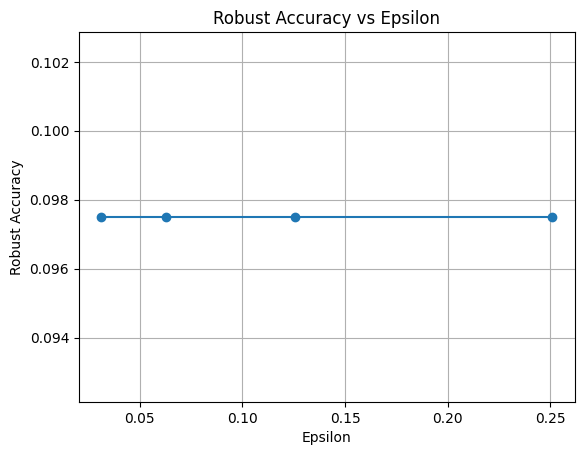

In [39]:

robust_accuracies = []

model_0.eval()  # this one sets model in evaluation mode.

for epsilon, alpha in zip(epsilons, alphas):
    correct_robust = 0
    total_robust = 0

    for images, labels in test_dataloader:      # go via the test dataset.
        perturbed_images = pgd_attack(model_0, images.clone(), labels, epsilon, alpha, num_steps)

        outputs = model_0(perturbed_images)          # evaluating perturbed images by model_0
        _, predicted = torch.max(outputs, 1)

        total_robust += labels.size(0)   #   Update statistics
        correct_robust += (predicted == labels).sum().item()

    robust_accuracy = correct_robust / total_robust  # this one finds the (robust) accuracy for the current epsilon.
    robust_accuracies.append(robust_accuracy)

plt.plot(epsilons, robust_accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.title('Robust Accuracy vs Epsilon')
plt.grid(True)
plt.show()


In [42]:
  print(robust_accuracies)

[0.0975, 0.0975, 0.0975, 0.0975]


6. Using matplotlib, plot 10 adversarial examples, along with their corresponding original images. Choose one original image classified per class (the 10 class should be represented). For each image (adversarial and original), add on the plot the predicted class of the image.


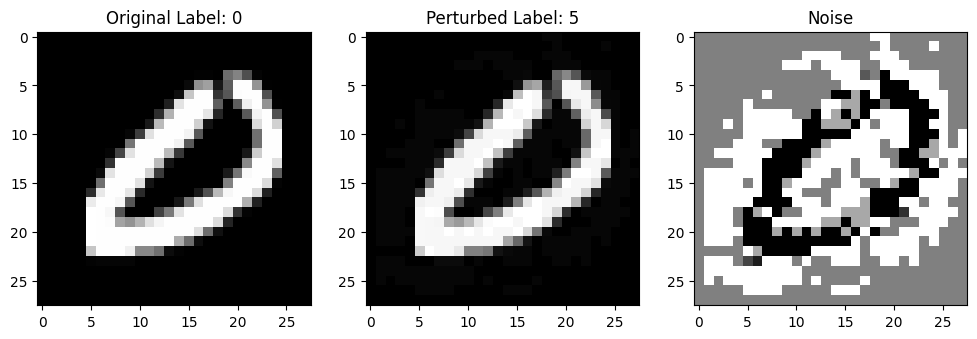

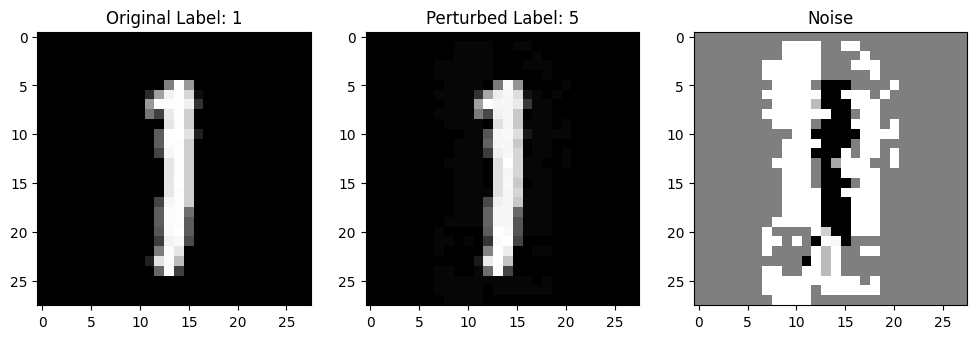

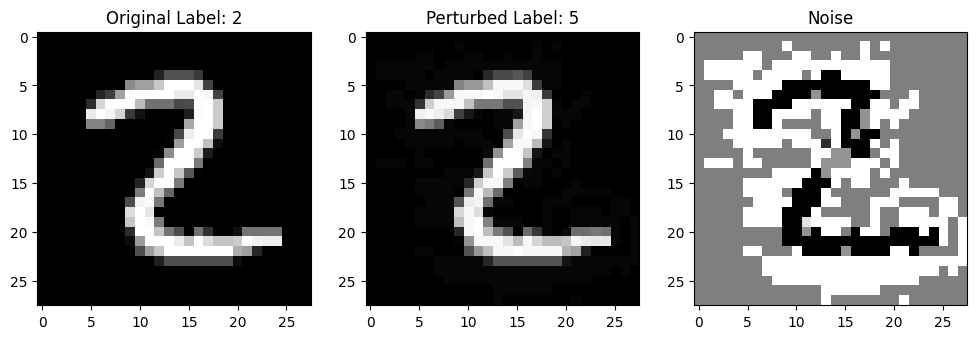

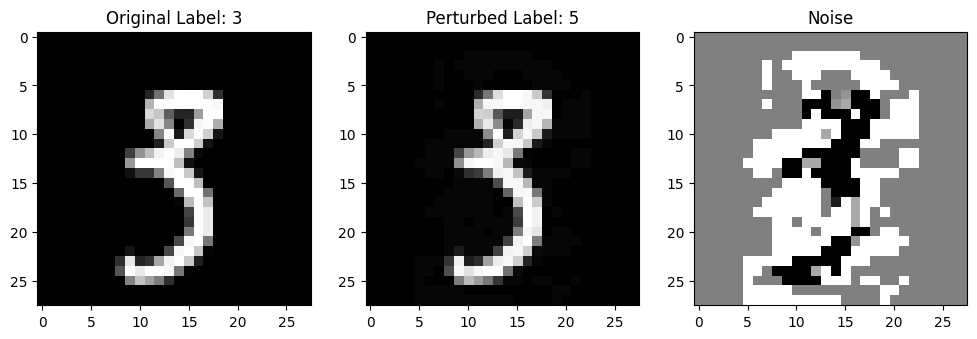

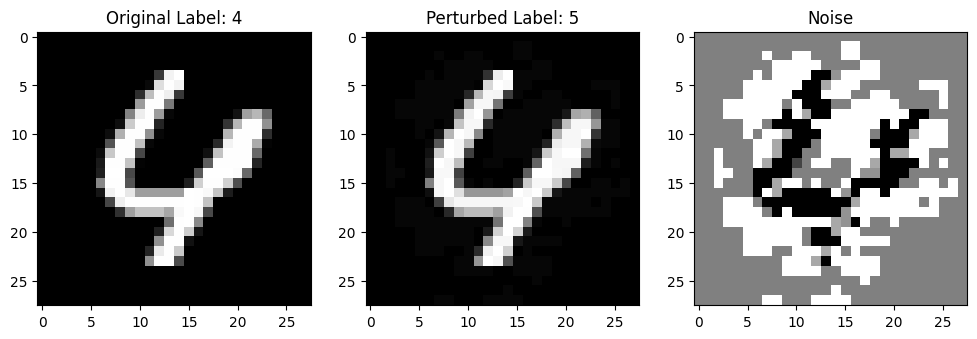

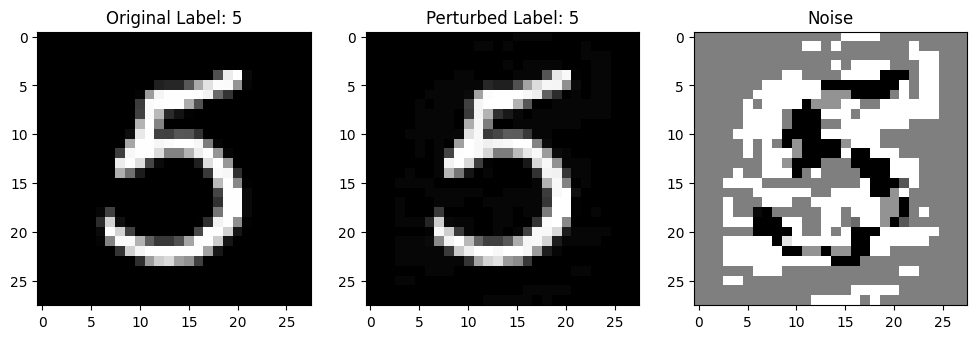

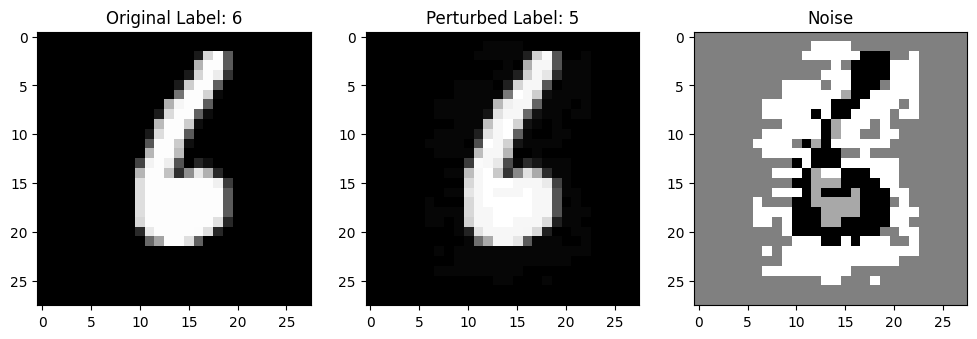

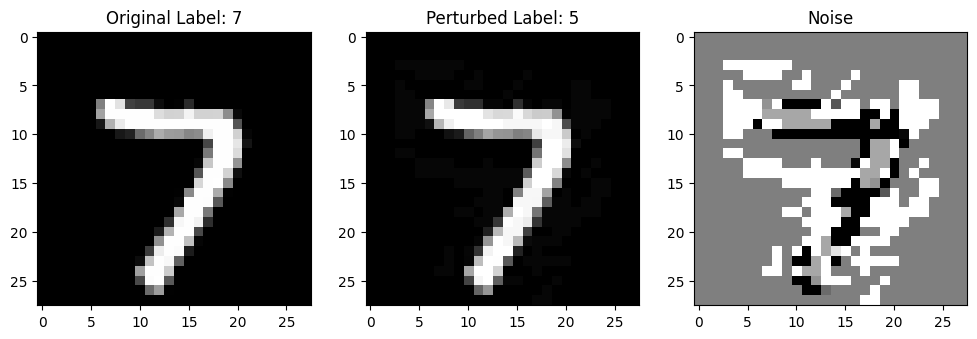

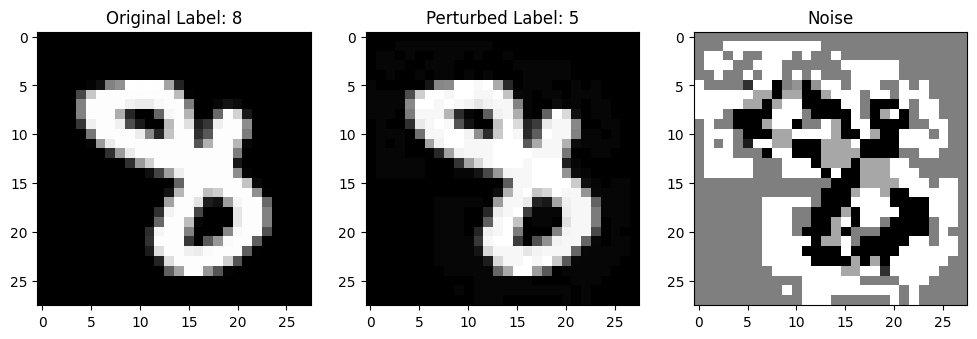

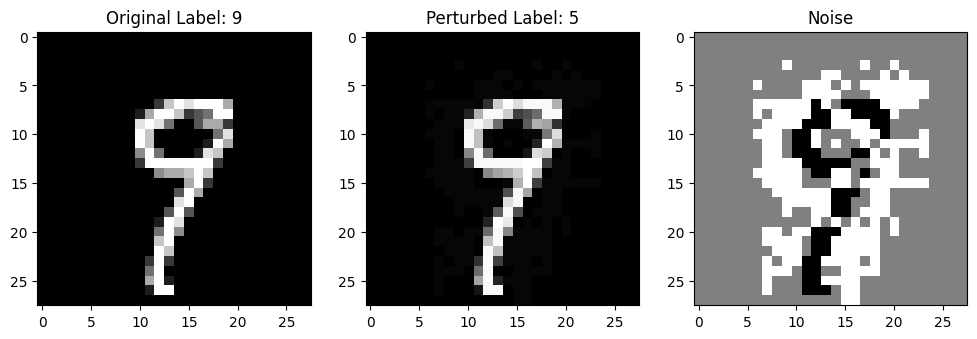

In [ ]:

def plot_images(original, perturbed, label_original, label_perturbed):
    plt.figure(figsize=(12, 4))

    # original image
    plt.subplot(1, 3, 1)
    if original.shape[-1] == 1:
        original = np.squeeze(original, axis=-1)
    plt.imshow(original, cmap='gray')
    plt.title(f'Original Label: {label_original}')

    # perturbed image
    plt.subplot(1, 3, 2)
    if perturbed.shape[-1] == 1:
        perturbed = np.squeeze(perturbed, axis=-1)
    plt.imshow(perturbed, cmap='gray')
    plt.title(f'Perturbed Label: {label_perturbed}')

    # Noise
    plt.subplot(1, 3, 3)
    noise = perturbed - original
    if noise.shape[-1] == 1:
        noise = np.squeeze(noise, axis=-1)
    plt.imshow(noise, cmap='gray')
    plt.title('Noise')

    plt.show()

# PGD attack on examples from each class
num_classes = 10
num_images_per_class = 1

for class_label in range(num_classes):
    # Find an example with the current class label
    for images, labels in test_dataloader:
        indices = (labels == class_label).nonzero()
        if indices.numel() > 0:
            example_index = indices[0].item()
            break

    # Select the example and apply PGD attack
    image = images[example_index]
    true_label = labels[example_index].item()

    # PGD attack
    perturbed_image = pgd_attack(model_0, image.clone().unsqueeze(0), labels[example_index].unsqueeze(0), epsilon, alpha, num_steps)

    # to convert images to numpy arrays for visualization
    original_image_np = np.transpose(image.numpy(), (1, 2, 0))
    perturbed_image_np = np.transpose(perturbed_image[0].numpy(), (1, 2, 0))

    # to plot original and perturbed images for the current class
    plot_images(original_image_np, perturbed_image_np, true_label, predicted[0].item())



**Question**: Please comment your results of this section.

**ANSWER HERE**


## 2. Transferability

In this section we will see how adversarial examples generated on one model can be adversarial on another model using a different architecture.
Let suppose a second model which parameters are unknown. For instance, it could be a model deploy on a cloud platform. We will use the examples generated in Section 1 on model_0 to fool this new model denoted model_1.
We say that model_0 is a surrogate for model_1.

1. Define a neural network architecture for MNIST different than the one used in Section 1.

In [ ]:
## GIVEN
class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
!pip install torch torchviz graphviz

from torchviz import make_dot
what_model = Net()

# input tensor with the same size as expected.
d_input = torch.randn(1, 1, 28, 28)

# computational graph
output = what_model(d_input)

# shows the computational graph
dot = make_dot(output, params=dict(what_model.named_parameters()))
dot.render("0", format="png", cleanup=True)


'0.png'

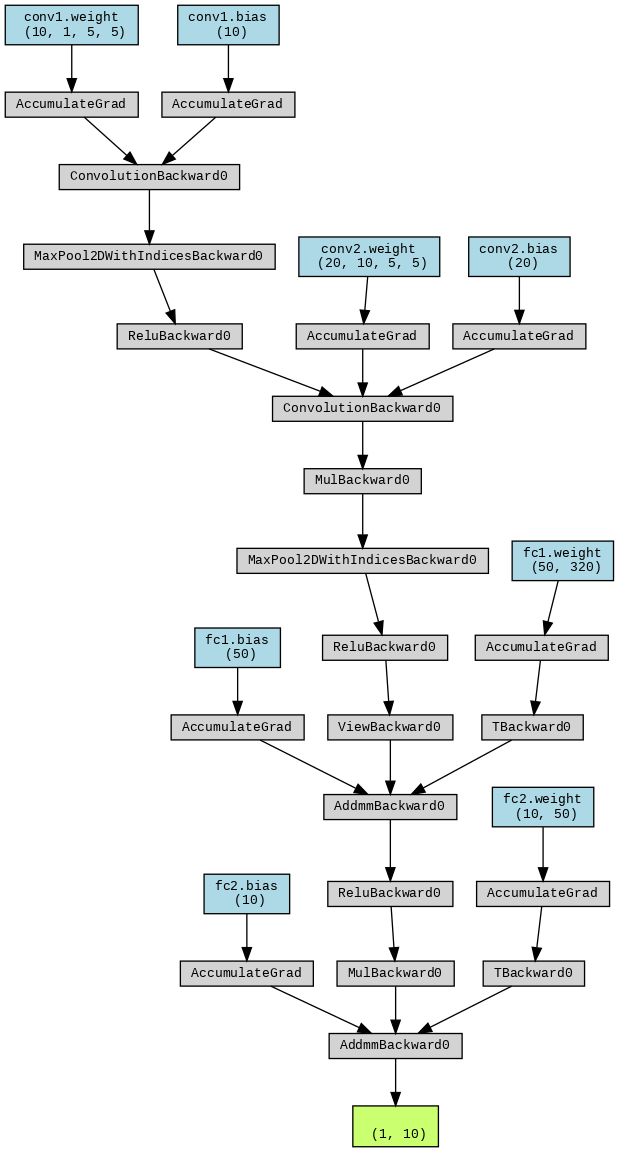

In [ ]:
from IPython.display import Image
Image("0.png")


2. Train the neural network model_1 with the same hyperparameters as model_0


Loss function (CrossEntropyLoss) and
Optimizer (SGD optimizer)

In [ ]:
model_1 = FullyConnectedNetwork()

optimizer_1 = optim.SGD(model_1.parameters(), lr=learning_rate, momentum=momentum) # SGD optimizer is used to update the parameters of the model while training.
criterion_1 = nn.CrossEntropyLoss()                                                # loss function CE is usually  for classification problems.

training_losses = []

for epoch in range(epochs):  # The training process is done in a loop over multiple epochs.
    model_1.train()          # Set it to train mode
    epoch_loss = 0.0         # to accumulate  total loss for each epoch.

    for batch_data, batch_labels in train_dataloader:
        outputs_1 = model_1(batch_data)                  # Forward pass
        loss_1 = criterion_1(outputs_1, batch_labels)

        optimizer_1.zero_grad()                          # Backward pass and optimization
        loss_1.backward()
        optimizer_1.step()

        epoch_loss += loss_1.item()

    average_epoch_loss = epoch_loss / len(train_dataloader)       # Average loss over all batches in the epoch
    training_losses.append(average_epoch_loss)

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {average_epoch_loss:.4f}')

Epoch 1/10, Training Loss: 0.5680
Epoch 2/10, Training Loss: 0.2103
Epoch 3/10, Training Loss: 0.1462
Epoch 4/10, Training Loss: 0.1086
Epoch 5/10, Training Loss: 0.0843
Epoch 6/10, Training Loss: 0.0687
Epoch 7/10, Training Loss: 0.0549
Epoch 8/10, Training Loss: 0.0451
Epoch 9/10, Training Loss: 0.0376
Epoch 10/10, Training Loss: 0.0306


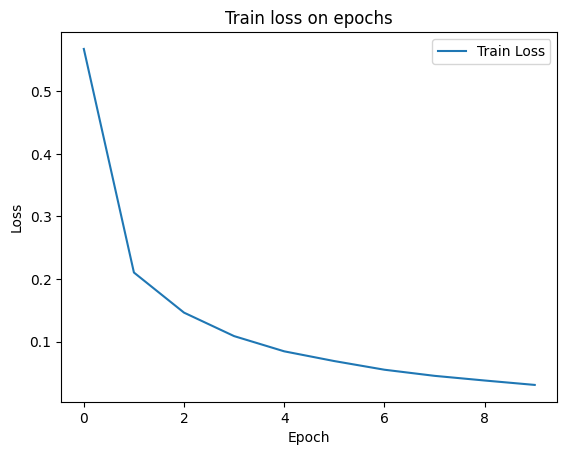

In [ ]:
# Plot the training loss
plt.plot(training_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train loss on epochs')
plt.legend()
plt.show()


3. What is the ratio of successful adversarial examples on model_0 that transfers to model_1 (ie. that are also adversarial for model_1)?


In [ ]:

# both models are set in evaluate mode
model_0.eval()
model_1.eval()

# Variables to keep track of successful adversarial examples
count_successful_transfer = 0
total_adversarial_examples = 0

for images, labels in test_dataloader:
    perturbed_images_0 = pgd_attack(model_0, images.clone(), labels, epsilon, alpha, num_steps)                 # PGD attack > model_0

    outputs_0 = model_0(perturbed_images_0)
    _, predicted_0 = torch.max(outputs_0, 1)

    perturbed_images_1 = pgd_attack(model_1, perturbed_images_0.clone(), labels, epsilon, alpha, num_steps)      # PGD attack > model_1

    outputs_1 = model_1(perturbed_images_1)
    _, predicted_1 = torch.max(outputs_1, 1)

    if (predicted_0 != labels).any() and (predicted_1 != labels).any():   #   checking if adversarial example on model_0 transfers to model_1 ?
        count_successful_transfer += 1

    total_adversarial_examples += labels.size(0)

ratio_successful_transfer = count_successful_transfer / total_adversarial_examples

print(f"Ratio of successful transfer attacks: {ratio_successful_transfer * 100:.2f}%")

Ratio of successful transfer attacks: 1.36%


What do you conclude about the robustness of the model? Can [secrecy](https://en.wikipedia.org/wiki/Security_through_obscurity) defend a model?

**ANSWER HERE**

## 3. Use adversarial training to robustify the model

Adversarial training is a common method to robustify models to adversarial examples as described in this paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083). In this section you should update the training loop such that 3/4 of the batch is used for training while the remaining forth is first perturbed with PGD and then used for training. You can limit the number of iterations of PDG to 10. Use model_0 architecture from Section 1 in this section.

1. Train model_robust using adversarial training. You may want to run it for additional epoch (x2) to reach a similar clean accuracy.

In [ ]:
n_iter = 10  # less iterations to accelerate training. But once trained, we will still evaluate the robust accuracy on more iterations for a more powerful attack.
eps = 32/255
alpha = eps / 5

In [ ]:
model_robust = Net()
model_robust.load_state_dict(model_0.state_dict())  # parameters of model_0

model_robust.train()

criterion = nn.CrossEntropyLoss()

training_losses_robust = []

n_iter = 10
eps = 32 / 255
alpha = eps / 5

optimizer_robust = optim.SGD(model_robust.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(2 * epochs):
    epoch_loss = 0.0

    for batch_data, batch_labels in train_dataloader:
        # split batch into training and perturbation subset (3/4 and 1/4).
        batch_size = batch_data.size(0)
        train_batch_size = int(3 / 4 * batch_size)

        train_data, train_labels = batch_data[:train_batch_size], batch_labels[:train_batch_size]
        perturb_data, perturb_labels = batch_data[train_batch_size:], batch_labels[train_batch_size:]

        # PGD attack on the perturbation subset
        for _ in range(n_iter):
            perturb_data = pgd_attack(model_robust, perturb_data.clone(), perturb_labels, eps, alpha, 1)

        updated_batch_data = torch.cat((train_data, perturb_data), dim=0)
        updated_batch_labels = torch.cat((train_labels, perturb_labels), dim=0)

        outputs = model_robust(updated_batch_data)
        loss = criterion(outputs, updated_batch_labels)

        optimizer_robust.zero_grad()
        loss.backward()
        optimizer_robust.step()

        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / len(train_dataloader)
    training_losses_robust.append(average_epoch_loss)

    print(f'Epoch {epoch + 1}/{2 * epochs}, Training Loss: {average_epoch_loss:.4f}')

Epoch 1/20, Training Loss: 0.3126
Epoch 2/20, Training Loss: 0.3111
Epoch 3/20, Training Loss: 0.3053
Epoch 4/20, Training Loss: 0.3057
Epoch 5/20, Training Loss: 0.3024
Epoch 6/20, Training Loss: 0.3010
Epoch 7/20, Training Loss: 0.2915
Epoch 8/20, Training Loss: 0.2893
Epoch 9/20, Training Loss: 0.2838
Epoch 10/20, Training Loss: 0.2820
Epoch 11/20, Training Loss: 0.2824
Epoch 12/20, Training Loss: 0.2794
Epoch 13/20, Training Loss: 0.2822
Epoch 14/20, Training Loss: 0.2785
Epoch 15/20, Training Loss: 0.2745
Epoch 16/20, Training Loss: 0.2723
Epoch 17/20, Training Loss: 0.2698
Epoch 18/20, Training Loss: 0.2712
Epoch 19/20, Training Loss: 0.2697
Epoch 20/20, Training Loss: 0.2726


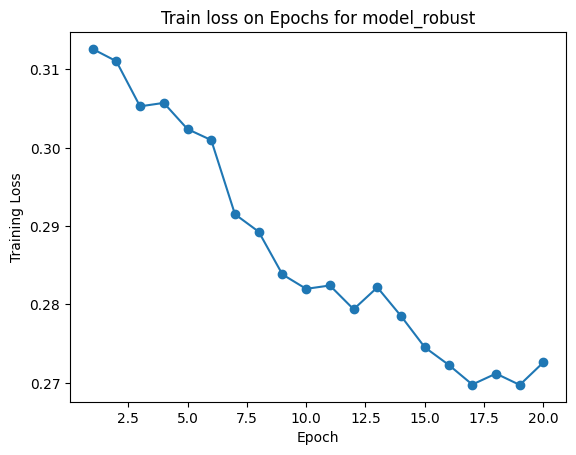

In [ ]:
plt.plot(range(1, 2 * epochs + 1), training_losses_robust, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Train loss on Epochs for model_robust')
plt.show()

2. Compare the robust accuracies of model_0 and model_robust using the same hyperparameters of PGD for different eps size, use a graph to show your results.

In [ ]:
n_examples = 1000
n_iter = 50
eps = [8/255, 16/255, 32/255, 64/255]
alpha = [e/10 for e in eps]

**Questions**: Please comment your results. Does adversarial training appears to be a valid defense? Please develop threads to validity of the robust accuracy evaluation carried out here. What could be done to improve the evaluation of the robustness of the model?

**ANSWER HERE**